# Validation of the PyPSA-Earth network

This notebooks investigates the data quality of the African network by 
comparing raw Open Street Map, processed PyPSA and World Bank data.
Looking at Nigeria only, we further compare the data to official Transmission
System Operator data.

The following quantities will be reviewed:
- inputs used by the pypsa-model:
  - network length
  - network topography
  - substation amount

To properly reproduce the findings obtained in this notebook,
please run the full snakemake workflow for the Africa.
To do so, please set ``countries = ["Africa"]`` in the ``config.yaml`` file.

## Preparation

### Import packages

In [1]:
# import packages

import logging
import os

import pypsa
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

# import geoplot
import pandas as pd

# import fiona  # ;help(fiona.open)
# import requests
from pandas.io.json import json_normalize  # convert json into dataframe

import shapely, shapely.prepared
from shapely.geometry import Point, LineString
from shapely.wkt import loads
from shapely.validation import make_valid
from pyproj import Geod  # to calculate length globally "Geodesic calculations"

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

In [4]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

val_path = "C:/Users/xenia/OneDrive/Desktop/Uni/NTNU/Thesis/Figures/Validation/"
plt.rcParams['font.size'] = 18

### Set main directory to root folder

In [4]:
# change current directory
import os
import sys

module_path = os.path.abspath(os.path.join('../../../')) # To import helpers
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
from _helpers import sets_path_to_root, country_name_2_two_digits, two_digits_2_name_country

sets_path_to_root("pypsa-earth-project")

Cant find the repo path.


## 1. Load data 




#### World Bank Data

Note: This dataset has been updated with transmission lines for the MENA region. This is the most complete and up-to-date open map of Africa's electricity grid network. This dataset serves as an updated and improved replacement for the Africa Infrastructure Country Diagnostic (AICD) data that was published in 2007. 

Coverage. This dataset includes planned and existing grid lines for all continental African countries and Madagascar, as well as the Middle East region. The lines range in voltage from sub-kV to 700 kV EHV lines, though there is a very large variation in the completeness of data by country. An interactive tool has been created for exploring this data, the Africa Electricity Grids Explorer. 

Sources. The primary sources for this dataset are as follows: 
- Africa Infrastructure Country Diagnostic (AICD) 
- OSM © OpenStreetMap contributors 
- For MENA: Arab Union of Electricity and country utilities. 
- For West Africa: West African Power Pool (WAPP) 
- GIS database 
- World Bank projects archive and 
- International Bank for Reconstruction and Development (IBRD) maps 
- There were many additional sources for specific countries and areas. This information is contained in the files of this dataset, and can also be found by browsing the individual country datasets, which contain more extensive information. 

Limitations. Some of the data, notably that from the AICD and from World Bank project archives, may be very out of date. Where possible this has been improved with data from other sources, but in many cases this wasn't possible. This varies significantly from country to country, depending on data availability. Thus, many new lines may exist which aren't shown, and planned lines may have completely changed or already been constructed. 
The data that comes from World Bank project archives has been digitized from PDF maps. This means that these lines should serve as an indication of extent and general location, but shouldn't be used for precisely location grid lines.

https://energydata.info/dataset/africa-electricity-transmission-and-distribution-grid-map-2017

In [5]:
url = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/144823/africagrid20170906final.geojson"
df_lines_world_bank = gpd.read_file(url).to_crs(epsg=3857)
values = ["Jordan", "Syria", "Lebanon", "Iraq", "Saudi Arabia", "Oman", "Yemen"]
df_lines_world_bank = df_lines_world_bank[
    df_lines_world_bank.country.isin(values) == False
]
df_lines_world_bank_existing = df_lines_world_bank[
    df_lines_world_bank.status == "Existing"
]
df_lines_world_bank_planned = df_lines_world_bank[
    df_lines_world_bank.status == "Planned"
]
df_lines_world_bank_existing_nigeria = df_lines_world_bank_existing[
    df_lines_world_bank_existing.country == "Nigeria"
]

KeyboardInterrupt: 

#### Raw Open Street Map Data
Created by our python script `download_osm_data.py`. Generate this data by running the pypsa-earth workflow through `snakemake -j8 download_osm_data` (see Snakefile if run fails)

In [6]:
# substations
home = "C:/Users/xenia/Desktop/Thesis_Code/Code/pypsa-earth_working"
substations_OSMraw_path = home + "/pypsa-earth/resources/osm/raw/all_raw_substations.geojson"
df_substations_raw_osm_africa = gpd.read_file(substations_OSMraw_path).to_crs(epsg=3857)
df_substations_raw_osm_nigeria = df_substations_raw_osm_africa[
    df_substations_raw_osm_africa.Country == "BO"
]

# lines
lines_OSMraw_path = home + "/pypsa-earth/resources/osm/raw/all_raw_lines.geojson"
df_lines_raw_osm_africa = gpd.read_file(lines_OSMraw_path).to_crs(epsg=3857)
df_lines_raw_osm_nigeria = df_lines_raw_osm_africa[
    df_lines_raw_osm_africa.Country == "BO"
]

#### Cleaned Open Street Map Data 
Created by our python script `clean_osm_data.py`. Generate this data by running the pypsa-Earth workflow through `snakemake -j8 clean_osm_data` (see Snakefile if run fails)

In [7]:
# substations
substations_OSMclean_path = home +"/pypsa-earth/resources/osm/clean/all_clean_substations.geojson"
df_substations_clean_osm_africa = gpd.read_file(substations_OSMclean_path)
df_substations_clean_osm_africa["geometry"] = (
    df_substations_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_substations_clean_osm_nigeria = df_substations_clean_osm_africa[
    df_substations_clean_osm_africa.country == "BO"
]

# lines
lines_OSMclean_path = home + "/pypsa-earth/resources/osm/clean/all_clean_lines.geojson"
df_lines_clean_osm_africa = gpd.read_file(lines_OSMclean_path)
df_lines_clean_osm_africa["geometry"] = (
    df_lines_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_lines_clean_osm_nigeria = df_lines_clean_osm_africa[
    df_lines_clean_osm_africa.country == "BO"
]
#display(df_lines_clean_osm_africa.head(3))
display(df_lines_clean_osm_nigeria.head(3))

,line_id,bus0,bus1,voltage,circuits,length,underground,under_construction,tag_type,tag_frequency,country,geometry
0,124795784,NaN,NaN,115000,1,41065.266991,False,False,line,50.0,BO,"LINESTRING (-7551371.974 -1837873.109, -7551458.859 -1837850.413, ..."
1,124797636,NaN,NaN,115000,1,55735.578608,False,False,line,50.0,BO,"LINESTRING (-7567165.905 -1809551.924, -7567125.173 -1809861.030, ..."
2,124798892,NaN,NaN,115000,1,30806.576772,False,False,line,50.0,BO,"LINESTRING (-7581967.880 -1820014.437, -7581990.600 -1820020.857, ..."


#### Country shape

In [8]:
countries_shape_path = home + "/pypsa-earth/resources/shapes/country_shapes.geojson"
africa_shape = gpd.read_file(countries_shape_path)
nigeria_shape = africa_shape.set_index("name").loc["BO"].geometry

## 2. Network length

The line length is given by voltage level in [km]. Note: when multiple circuits are available, the length of the line is multiplied accordingly. The World Bank data does not include directly circuit information, however, since maps sometimes show lines in parallel some circuits are included.

#### Raw OSM

,id,tags.power,Type,Country,Length,tags.cables,tags.voltage,tags.circuits,tags.frequency,geometry,length_by_geometry,cables_fix,length_km
0,46148505.0,line,Way,BO,1124.659881,NaN,NaN,NaN,NaN,"LINESTRING (-7041649.821 -2014873.688, -7041573.156 -2015012.882, ...",1124.659881,3,1124.659881
1,102695687.0,line,Way,BO,2387.925010,NaN,NaN,NaN,NaN,"LINESTRING (-7697179.000 -1809783.608, -7696481.483 -1810557.650, ...",2387.925010,3,2387.925010
2,124795784.0,line,Way,BO,41065.266991,3,115000,NaN,50,"LINESTRING (-7551371.974 -1837873.109, -7551458.859 -1837850.413, ...",41065.266991,3,41065.266991
3,124797636.0,line,Way,BO,55735.578608,3,115000,NaN,50,"LINESTRING (-7567165.905 -1809551.924, -7567125.173 -1809861.030, ...",55735.578608,3,55735.578608
4,124798892.0,line,Way,BO,30806.576772,3,115000,NaN,50,"LINESTRING (-7581967.880 -1820014.437, -7581990.600 -1820020.857, ...",30806.576772,3,30806.576772


C:\Users\xenia\AppData\Local\Temp\ipykernel_5704\2610269395.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_lines_raw_osm_africa.groupby('tags.voltage').sum()


tags.voltage
115000    1.838165e+06
132000    7.297498e+04
230000    3.345016e+06
69000     1.609045e+05
Name: Length, dtype: float64

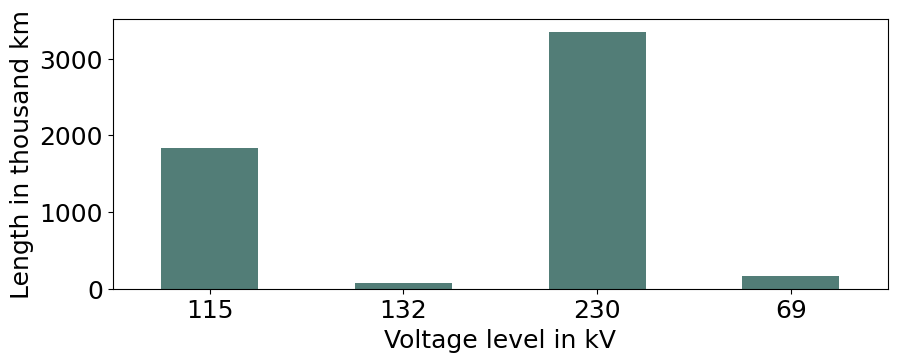

In [37]:
df_lines_raw_osm_africa["length_by_geometry"] = df_lines_raw_osm_africa.to_crs(
    epsg=3857
).geometry.length
display(df_lines_raw_osm_africa.head())
grouped = df_lines_raw_osm_africa.groupby('tags.voltage').sum()
BO_voltage_km = grouped['Length']

# Plot
(BO_voltage_km/1000).plot.bar(color=teal3, figsize = (10,3.5))
plt.xlabel('Voltage level in kV')
plt.ylabel('Length in thousand km')
plt.xticks(ticks = [0,1,2,3], labels = [115,132,230,69],rotation = 0)
#plt.title('Raw OSM data - lines Bolivia')
plt.savefig(val_path+f'line_length_raw_OSM.pdf', dpi=300, format='pdf', bbox_inches='tight')
BO_voltage_km

In [22]:
# AFRICA
df_lines_raw_osm_africa["cables_fix"] = df_lines_raw_osm_africa["tags.cables"].copy()
df_lines_raw_osm_africa.loc[
    df_lines_raw_osm_africa["tags.cables"].isnull()
    | df_lines_raw_osm_africa["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_africa["length_km"] = (
    df_lines_raw_osm_africa.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_africa["cables_fix"].astype(float)
    / 3
)
length_raw_osm = (
    df_lines_raw_osm_africa.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_raw_osm = pd.DataFrame(length_raw_osm)
df_raw_osm.index = voltage

lengths_africa = pd.DataFrame()
df = df_raw_osm
lengths_africa["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_africa["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_africa["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_africa["scope"] = "Bolivia"
lengths_africa["reference"] = "Open Street Map (raw)"

### NIGERIA
df_lines_raw_osm_nigeria["cables_fix"] = df_lines_raw_osm_nigeria["tags.cables"].copy()
df_lines_raw_osm_nigeria.loc[
    df_lines_raw_osm_nigeria["tags.cables"].isnull()
    | df_lines_raw_osm_nigeria["tags.cables"].isna(),
    "cables_fix",
] = 3  # when NaN or None, set default value
df_lines_raw_osm_nigeria["length_km"] = (
    df_lines_raw_osm_nigeria.to_crs(epsg=3857).geometry.length
    * df_lines_raw_osm_nigeria["cables_fix"].astype(float)
    / 3
)
length_raw_osm = (
    df_lines_raw_osm_nigeria.groupby(by=["tags.voltage"]).length_km.sum() / 1000
)
voltage = pd.to_numeric(
    pd.DataFrame(length_raw_osm).reset_index()["tags.voltage"], errors="coerce"
)
df_lines_raw_osm_nigeria = pd.DataFrame(length_raw_osm)
df_lines_raw_osm_nigeria.index = voltage

lengths_ng = pd.DataFrame()
df = df_lines_raw_osm_nigeria
lengths_ng["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_ng["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_ng["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_ng["scope"] = "Bolivia"
lengths_ng["reference"] = "Open Street Map (raw)"

### COMBINE OUTPUT
osm_raw_lengths = pd.concat([lengths_africa, lengths_ng])


,110-220kV,220-380kV,380+kV,scope,reference
length_km,2022.471534,4193.795857,0.0,Bolivia,Open Street Map (raw)
length_km,2022.471534,4193.795857,0.0,Bolivia,Open Street Map (raw)


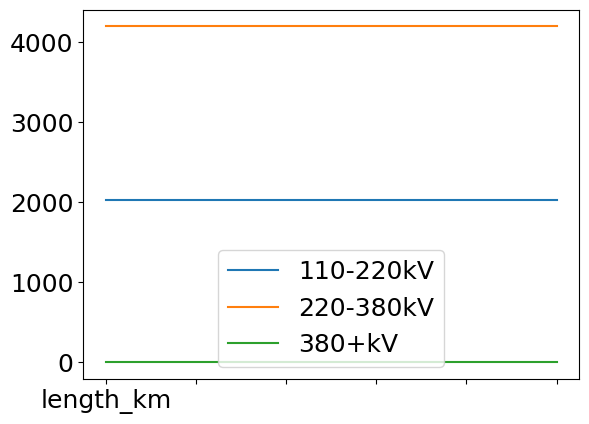

In [23]:


osm_raw_lengths.plot()
osm_raw_lengths

#### Clean OSM

          110-220kV    220-380kV  380+kV
length  1975.880529  4193.795857     0.0
        line_id  bus0  bus1  voltage  circuits     length  underground  \
0     124795784   NaN   NaN   115000         1  41.065267        False   
1     124797636   NaN   NaN   115000         1  55.735579        False   
2     124798892   NaN   NaN   115000         1  30.806577        False   
3     174006319   NaN   NaN   115000         1  16.438438        False   
4     174006324   NaN   NaN   115000         1  18.607982        False   
..          ...   ...   ...      ...       ...        ...          ...   
145  1067603091   NaN   NaN   230000         1  10.662220        False   
146  1124929571   NaN   NaN   115000         1   2.166447        False   
147  1124929572   NaN   NaN   115000         1   0.545053        False   
148  1132100019   NaN   NaN   115000         1   1.802020        False   
149  1134182172   NaN   NaN   115000         1   6.792737        False   

     under_construction tag_t

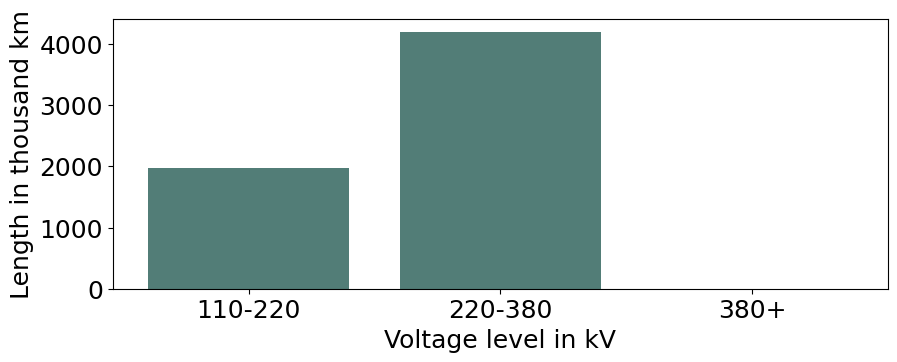

In [36]:
### AFRICA
df = df_lines_clean_osm_africa
df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_africa = pd.DataFrame()
df = df_clean_osm
lengths_africa["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_africa["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_africa["380+kV"] = df.loc[(df.index >= 380000)].sum()
lengths_africa["scope"] = "Bolivia"
lengths_africa["reference"] = "Open Street Map (clean)"

### NIGERIA
df = df_lines_clean_osm_nigeria
df["length"] = df.to_crs(epsg=3857).geometry.length * df.circuits / 1000
voltage = df.groupby(by=["voltage"]).length.sum()
df_clean_osm = pd.DataFrame(voltage)
lengths_ng = pd.DataFrame()
df = df_clean_osm
lengths_ng["110-220kV"] = df.loc[(df.index >= 110000) & (df.index < 220000)].sum()
lengths_ng["220-380kV"] = df.loc[(df.index >= 220000) & (df.index < 380000)].sum()
lengths_ng["380+kV"] = df.loc[(df.index >= 380000)].sum()
print(lengths_ng)

### COMBINE OUTPUT
osm_clean_lengths = pd.concat([lengths_africa, lengths_ng])
osm_clean_lengths

plt.figure(figsize = (10,3.5))
plt.bar(lengths_ng.columns, lengths_ng.loc['length'],color=teal3)
plt.xlabel('Voltage level in kV')
plt.ylabel('Length in thousand km')
plt.xticks(ticks = [0,1,2], labels = ['110-220','220-380','380+'],rotation = 0)
#plt.title('Raw OSM data - lines Bolivia')
plt.savefig(val_path+f'line_length_clean_OSM.pdf', dpi=300, format='pdf', bbox_inches='tight')

print(df_lines_clean_osm_africa)

## 3. Network topology

In this subsection, the data publicly on the network power system are compared. In particular, the main data that are being compared are:
- Layout of the network as shown by images (Section 1.1)
- Total length of the line (Section 1.2)

The data used for the comparison have been taken from public reliable sources, with strong focus on the website of the Nigerian Transmission operator: Nigerian Transmission Company ([TCN](https://www.tcn.org.ng/)).

In the Section 1.1, the network layout obtained by the workflow is drawn to be possibly compared with the image as shown in the public website of the [Nigerian Transmission System Operator](https://www.tcn.org.ng/). The image below, dated 2016, available from the [Nigerian Transmission System Operator](https://www.tcn.org.ng/), depicts the national power grid of Nigeria.

![Nigerian transmission system](../../images/Nigeria_data/Nigeria_network_map.png)
[Source link](https://www.tcn.org.ng/page_repository.php)

c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


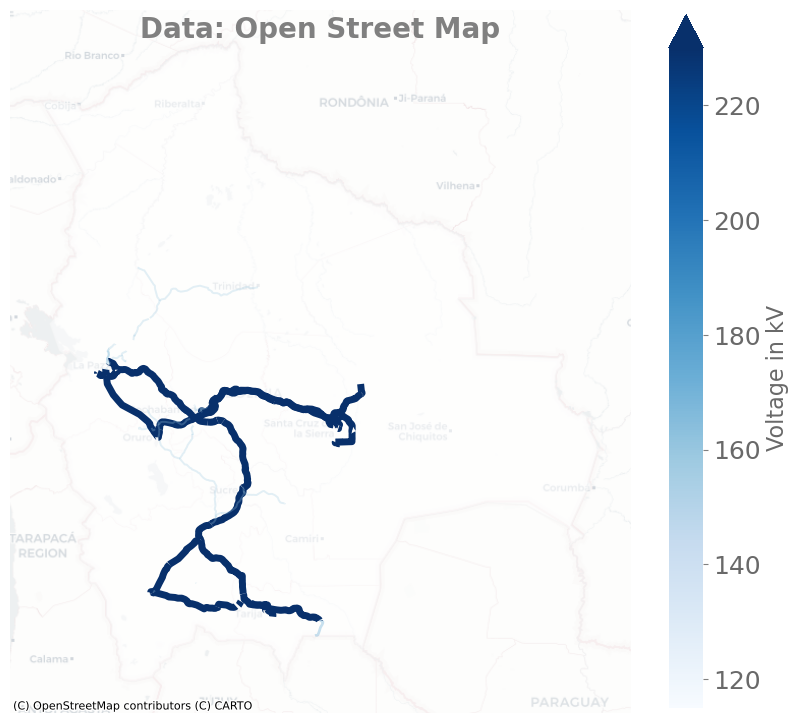

In [38]:
import contextily as cx  # Need to be installed `pip3 install contextily`
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl

# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = africa_shape.to_crs(epsg="3857").plot(
    figsize=(20 * size, 20 * size), alpha=0.5, facecolor="white", edgecolor="whitesmoke"
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df = df_lines_clean_osm_africa[df_lines_clean_osm_africa.country == "NG"]
df = df_lines_clean_osm_africa[df_lines_clean_osm_africa.voltage >= 110000]

# Scale and format stuff
blues = cm.get_cmap("Blues")
dfact = 0.28  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage"] - df["voltage"].min()) / (
    df["voltage"].max() - df["voltage"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=blues(normalized_voltage + 0.1),
    legend=True,
)
ax.set_title(
    "Data: Open Street Map",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()

# Colorbar
cmap = blues
norm = mpl.colors.Normalize(
    vmin=df["voltage"].min() / 1000, vmax=df["voltage"].max() / 1000
)
cbar = plt.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=ax,
    orientation="vertical",
    extend="max",
    shrink=0.9,
)
cbar.set_label("Voltage in kV", fontsize=16, color="dimgrey")
# ticks & edge modification of cbar
cbar.ax.yaxis.set_tick_params(color="grey")
plt.setp(plt.getp(cbar.ax.axes, "yticklabels"), color="dimgrey")
cbar.outline.set_edgecolor(None)  # set colorbar edgecolor

# plt.savefig("africa-network-comparison-osm.pdf", bbox_inches='tight')

c:\Users\xenia\miniconda3\envs\pypsa-earth-mos\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


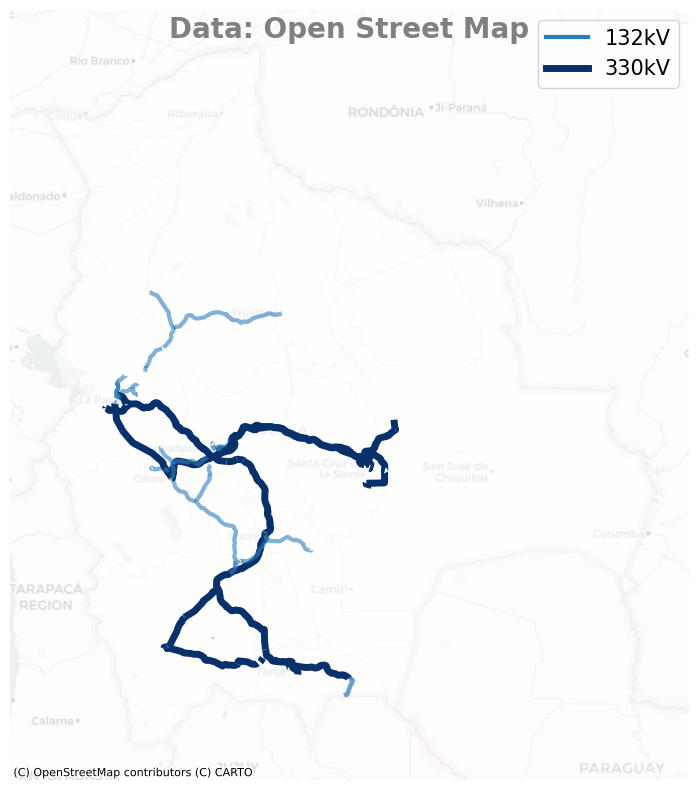

In [40]:
from matplotlib import cm
import contextily as cx  # Need to be installed `pip3 install contextily`
import matplotlib.pyplot as plt
import matplotlib as mpl

# adapt all sizes
size = 0.5
# Create the basemap that is called by ax
ax = (
    africa_shape[africa_shape.name == "BO"]
    .to_crs(epsg="3857")
    .plot(
        figsize=(20 * size, 20 * size),
        alpha=0.5,
        facecolor="white",
        edgecolor="whitesmoke",
    )
)

# Create open street map background map
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, alpha=0.4)

# Create open street map background map
df0 = df_lines_clean_osm_africa[df_lines_clean_osm_africa.country == "BO"]
df = df0[df0.voltage >= 110000]

# Scale and format stuff
blues = cm.get_cmap("Blues")
dfact = 0.6  # impacts min-max differences of weight, transparency and color
widthscale = 10 * size
df["normalized_v"] = (1 - dfact) * (df["voltage"] - df["voltage"].min()) / (
    df["voltage"].max() - df["voltage"].min()
) + dfact
line = df
normalized_voltage = df.normalized_v

line.plot(
    ax=ax,
    alpha=normalized_voltage,
    linewidth=normalized_voltage * widthscale,
    color=blues(normalized_voltage + 0.1),
)

# Legend
ax.set_title(
    "Data: Open Street Map",
    fontsize=40 * size,
    y=1.0,
    pad=-40 * size,
    fontweight="bold",
    color="grey",
)
ax.set_axis_off()
plt.plot(
    0.6, label="132kV", color=blues(normalized_voltage.unique()[0] + 0.1), linewidth=3
)
plt.plot(
    1, label="330kV", color=blues(normalized_voltage.unique()[1] + 0.1), linewidth=5
)
plt.rc("legend", fontsize=15)
ax.legend()

# plt.savefig("nigeria-network-comparison-osm.pdf", bbox_inches='tight')